# Summary
- mincorr and minlinreg are similar. maxcorr and maxlinreg are similar. 
- spearman among different layers is lower (even goes negative) in lower layers for:
    - bert_large
    - openai
    - bert_base
  
  but not true for elmo or calypso
- intermediate layers appear most similar to the next and previous layer of the same model
- lower layers (eg. in bert) are more correlated with lower layers in other models
- in the larger bert, new layers are effectively inserted between old ones (see heatmap), although the last few layers don't seem to follow this. Corroborates the result in "Similarity of Neural Network Representations Revisited"
- xlnet large and bert large have an interesting relationship. The lower levels of xlnet seem to correspond to the higher layers of bert

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns

In [2]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/johnmwu/contextual-corr-analysis/results8_"
res_fname = {method : base + method for method in 
                {"maxcorr", "mincorr", "maxlinreg", "minlinreg", "cca", "lincka", "rbfcka"}}

res_d = {}
res_d["maxcorr"] = json.load(open(res_fname["maxcorr"], "r"))
res_d["mincorr"] = json.load(open(res_fname["mincorr"], "r"))
res_d["maxlinreg"] = json.load(open(res_fname["maxlinreg"], "r"))
res_d["minlinreg"] = json.load(open(res_fname["minlinreg"], "r"))

network_l = [network for network in res_d["maxcorr"]]

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(res_d["maxcorr"][network])

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [3]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [4]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = [neuron[0] for neuron in res_d[method][network]]

In [5]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [6]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_large_cased_0
           maxlinreg   mincorr   maxcorr  minlinreg
maxlinreg   1.000000  0.176797  0.648580   0.267656
mincorr     0.176797  1.000000 -0.265457   0.841917
maxcorr     0.648580 -0.265457  1.000000  -0.205201
minlinreg   0.267656  0.841917 -0.205201   1.000000
bert_large_cased_1
           maxlinreg   mincorr   maxcorr  minlinreg
maxlinreg   1.000000  0.035103  0.966639   0.278610
mincorr     0.035103  1.000000 -0.017512   0.744525
maxcorr     0.966639 -0.017512  1.000000   0.215490
minlinreg   0.278610  0.744525  0.215490   1.000000
bert_large_cased_2
           maxlinreg   mincorr   maxcorr  minlinreg
maxlinreg   1.000000  0.131480  0.977871   0.452293
mincorr     0.131480  1.000000  0.115634   0.739880
maxcorr     0.977871  0.115634  1.000000   0.435666
minlinreg   0.452293  0.739880  0.435666   1.000000
bert_large_cased_3
           maxlinreg   mincorr   maxcorr  minlinreg
maxlinreg   1.000000  0.121375  0.980589   0.376619
mincorr     0.121375  1.000000  0.098167

           maxlinreg   mincorr   maxcorr  minlinreg
maxlinreg   1.000000  0.543199  0.962435   0.800507
mincorr     0.543199  1.000000  0.530406   0.806534
maxcorr     0.962435  0.530406  1.000000   0.782872
minlinreg   0.800507  0.806534  0.782872   1.000000
xlnet_large_cased_19
           maxlinreg   mincorr   maxcorr  minlinreg
maxlinreg   1.000000  0.533648  0.952954   0.771555
mincorr     0.533648  1.000000  0.492079   0.805732
maxcorr     0.952954  0.492079  1.000000   0.734694
minlinreg   0.771555  0.805732  0.734694   1.000000
xlnet_large_cased_20
           maxlinreg   mincorr   maxcorr  minlinreg
maxlinreg   1.000000  0.520807  0.943028   0.749236
mincorr     0.520807  1.000000  0.490462   0.811357
maxcorr     0.943028  0.490462  1.000000   0.735096
minlinreg   0.749236  0.811357  0.735096   1.000000
xlnet_large_cased_21
           maxlinreg   mincorr   maxcorr  minlinreg
maxlinreg   1.000000  0.521602  0.887033   0.723367
mincorr     0.521602  1.000000  0.415716   0.817193
m

### Distributions

In [7]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        corr_ar = np.stack([
            list(notated_neuron[1].values())
            for notated_neuron in res_d[method][network]
        ])
        corr_df = pd.DataFrame(np.abs(corr_ar),
                              columns=[net for net in network_l if net != network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_large_cased_0:

maxlinreg

maxcounts
bert_large_cased_1    1021
bert_base_cased_0        3
dtype: int64

mincounts
xlnet_large_cased_23     1011
xlnet_large_cased_0         8
openai_transformer_12       4
elmo_original_0             1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.267658  0.390258
min  0.267658  1.000000  0.936902
med  0.390258  0.936902  1.000000

mincorr

maxcounts
bert_large_cased_1                  981
bert_base_cased_0                    40
calypso_transformer_6_512_base_0      2
openai_transformer_2                  1
dtype: int64

mincounts
xlnet_large_cased_23    687
elmo_4x4096_512_2        67
xlnet_large_cased_20     50
xlnet_large_cased_22     34
xlnet_large_cased_16     32
xlnet_large_cased_19     26
xlnet_large_cased_21     20
xlnet_large_cased_18     19
xlnet_large_cased_17     19
xlnet_large_cased_15     18
elmo_4x4096_512_3         9
xlnet_large_cased_13      9
xlnet_large_cased_14      4
bert_base_cased_8         3

          max       min       med
max  1.000000  0.115634  0.258173
min  0.115634  1.000000  0.853319
med  0.258173  0.853319  1.000000

maxcorr

maxcounts
bert_large_cased_3    1013
bert_large_cased_1      11
dtype: int64

mincounts
xlnet_large_cased_23                564
elmo_4x4096_512_2                    61
xlnet_large_cased_22                 56
xlnet_large_cased_20                 46
xlnet_large_cased_16                 40
xlnet_large_cased_21                 39
xlnet_large_cased_15                 32
xlnet_large_cased_19                 30
xlnet_large_cased_18                 23
elmo_4x4096_512_3                    18
xlnet_large_cased_17                 16
xlnet_large_cased_14                 14
xlnet_large_cased_13                 11
xlnet_large_cased_12                  6
bert_large_cased_24                   5
xlnet_large_cased_11                  5
elmo_original_0                       5
xlnet_large_cased_7                   4
xlnet_large_cased_2                   4
elmo_4

          max       min       med
max  1.000000  0.129541  0.236383
min  0.129541  1.000000  0.839800
med  0.236383  0.839800  1.000000

maxcorr

maxcounts
bert_large_cased_5    740
bert_large_cased_3    284
dtype: int64

mincounts
xlnet_large_cased_23                583
xlnet_large_cased_22                 63
xlnet_large_cased_20                 49
elmo_4x4096_512_2                    42
xlnet_large_cased_16                 41
xlnet_large_cased_19                 33
xlnet_large_cased_15                 31
elmo_4x4096_512_3                    26
xlnet_large_cased_17                 22
xlnet_large_cased_18                 20
xlnet_large_cased_21                 18
xlnet_large_cased_14                 16
xlnet_large_cased_13                 14
xlnet_large_cased_12                  9
elmo_original_2                       6
xlnet_large_cased_11                  5
bert_base_cased_12                    5
elmo_original_1                       4
xlnet_large_cased_7                   4
xlnet_la

          max       min       med
max  1.000000  0.230968  0.354558
min  0.230968  1.000000  0.831749
med  0.354558  0.831749  1.000000

maxcorr

maxcounts
bert_large_cased_7                  780
bert_large_cased_5                  243
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                626
xlnet_large_cased_22                 42
elmo_4x4096_512_2                    40
xlnet_large_cased_20                 34
xlnet_large_cased_16                 31
xlnet_large_cased_13                 24
elmo_4x4096_512_3                    22
xlnet_large_cased_19                 21
xlnet_large_cased_14                 19
xlnet_large_cased_15                 18
xlnet_large_cased_21                 14
elmo_4x4096_512_4                    14
xlnet_large_cased_17                 13
elmo_original_0                      12
xlnet_large_cased_18                 10
openai_transformer_0                 10
xlnet_large_cased_12                  9
openai_transformer_1

          max       min       med
max  1.000000  0.297940  0.453522
min  0.297940  1.000000  0.852725
med  0.453522  0.852725  1.000000

maxcorr

maxcounts
bert_large_cased_7                  612
bert_large_cased_9                  411
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                616
elmo_4x4096_512_2                    46
elmo_4x4096_512_3                    40
xlnet_large_cased_22                 40
xlnet_large_cased_16                 29
xlnet_large_cased_20                 24
xlnet_large_cased_15                 17
calypso_transformer_6_512_base_6     14
xlnet_large_cased_18                 13
xlnet_large_cased_14                 13
xlnet_large_cased_17                 13
elmo_4x4096_512_4                    12
elmo_original_2                      12
xlnet_large_cased_13                 12
elmo_original_0                      11
xlnet_large_cased_21                 11
openai_transformer_0                 11
openai_transformer_1

          max      min       med
max  1.000000  0.28901  0.444645
min  0.289010  1.00000  0.839040
med  0.444645  0.83904  1.000000

maxcorr

maxcounts
bert_large_cased_9     973
bert_large_cased_11     51
dtype: int64

mincounts
xlnet_large_cased_23                580
elmo_4x4096_512_3                    43
elmo_4x4096_512_2                    42
xlnet_large_cased_22                 32
xlnet_large_cased_20                 29
xlnet_large_cased_16                 29
xlnet_large_cased_19                 20
xlnet_large_cased_18                 19
xlnet_large_cased_15                 18
openai_transformer_12                18
elmo_4x4096_512_0                    17
elmo_original_0                      16
xlnet_large_cased_13                 15
xlnet_large_cased_17                 13
xlnet_large_cased_21                 12
xlnet_large_cased_14                 12
elmo_original_2                      11
elmo_4x4096_512_4                    11
xlnet_large_cased_1                  10
openai_tra

          max       min       med
max  1.000000  0.410630  0.519404
min  0.410630  1.000000  0.830402
med  0.519404  0.830402  1.000000

maxcorr

maxcounts
bert_large_cased_11                 822
bert_large_cased_13                 201
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                620
xlnet_large_cased_22                 53
elmo_4x4096_512_2                    36
xlnet_large_cased_20                 26
elmo_4x4096_512_3                    24
openai_transformer_12                19
xlnet_large_cased_19                 18
elmo_4x4096_512_0                    16
xlnet_large_cased_16                 15
xlnet_large_cased_18                 14
elmo_original_0                      13
openai_transformer_0                 13
xlnet_large_cased_17                 13
xlnet_large_cased_15                 11
openai_transformer_1                 11
xlnet_large_cased_2                  10
xlnet_large_cased_21                 10
xlnet_large_cased_1 

          max       min       med
max  1.000000  0.520546  0.571156
min  0.520546  1.000000  0.852921
med  0.571156  0.852921  1.000000

maxcorr

maxcounts
bert_large_cased_13                 839
bert_large_cased_15                 184
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                650
elmo_original_0                      32
elmo_4x4096_512_0                    31
xlnet_large_cased_22                 27
openai_transformer_0                 26
elmo_4x4096_512_3                    26
xlnet_large_cased_1                  24
elmo_4x4096_512_2                    21
xlnet_large_cased_21                 15
openai_transformer_1                 15
xlnet_large_cased_20                 13
xlnet_large_cased_19                 11
openai_transformer_12                10
xlnet_large_cased_18                  9
xlnet_large_cased_15                  9
xlnet_large_cased_16                  9
xlnet_large_cased_2                   8
xlnet_large_cased_13

          max       min       med
max  1.000000  0.540294  0.580178
min  0.540294  1.000000  0.854117
med  0.580178  0.854117  1.000000

maxcorr

maxcounts
bert_large_cased_15                 839
bert_large_cased_17                 184
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                574
elmo_original_0                      39
openai_transformer_0                 36
elmo_4x4096_512_2                    35
elmo_4x4096_512_0                    34
xlnet_large_cased_1                  32
elmo_4x4096_512_3                    31
xlnet_large_cased_22                 31
xlnet_large_cased_2                  19
openai_transformer_1                 18
openai_transformer_12                14
xlnet_large_cased_19                 13
xlnet_large_cased_21                 12
xlnet_large_cased_20                 11
elmo_original_2                      11
openai_transformer_2                 11
xlnet_large_cased_0                   8
elmo_4x4096_512_4   

xlnet_large_cased_23                398
elmo_original_0                     100
elmo_4x4096_512_0                    60
openai_transformer_0                 57
xlnet_large_cased_1                  42
elmo_4x4096_512_2                    41
elmo_4x4096_512_3                    37
xlnet_large_cased_2                  31
openai_transformer_1                 28
openai_transformer_12                18
xlnet_large_cased_22                 17
xlnet_large_cased_0                  16
elmo_original_2                      11
bert_base_cased_0                    11
bert_base_cased_1                    10
elmo_4x4096_512_1                    10
xlnet_large_cased_21                  9
elmo_4x4096_512_4                     9
calypso_transformer_6_512_base_6      9
calypso_transformer_6_512_base_0      8
bert_large_cased_0                    7
xlnet_large_cased_19                  6
bert_large_cased_1                    6
openai_transformer_11                 6
elmo_original_1                       6


          max       min       med
max  1.000000  0.435207  0.450828
min  0.435207  1.000000  0.890689
med  0.450828  0.890689  1.000000

maxcorr

maxcounts
bert_large_cased_19    920
bert_large_cased_21    103
xlnet_large_cased_0      1
dtype: int64

mincounts
xlnet_large_cased_23                385
elmo_4x4096_512_2                    83
elmo_original_0                      63
openai_transformer_0                 61
elmo_4x4096_512_3                    52
elmo_4x4096_512_0                    52
xlnet_large_cased_2                  35
xlnet_large_cased_1                  28
openai_transformer_1                 23
openai_transformer_12                19
elmo_original_2                      18
bert_base_cased_0                    14
bert_large_cased_0                   11
elmo_4x4096_512_1                    10
xlnet_large_cased_22                 10
xlnet_large_cased_3                   9
xlnet_large_cased_21                  8
xlnet_large_cased_17                  8
bert_base_cased_1  

          max       min       med
max  1.000000  0.430039  0.454694
min  0.430039  1.000000  0.887666
med  0.454694  0.887666  1.000000

maxcorr

maxcounts
bert_large_cased_23    690
bert_large_cased_21    334
dtype: int64

mincounts
xlnet_large_cased_23                297
elmo_4x4096_512_2                    98
elmo_original_0                      72
openai_transformer_0                 62
elmo_4x4096_512_3                    54
elmo_4x4096_512_0                    51
openai_transformer_12                37
xlnet_large_cased_2                  34
openai_transformer_1                 26
xlnet_large_cased_1                  21
xlnet_large_cased_3                  18
elmo_4x4096_512_1                    16
elmo_original_2                      16
xlnet_large_cased_16                 12
bert_large_cased_5                   12
elmo_4x4096_512_4                    10
bert_large_cased_4                   10
xlnet_large_cased_18                 10
xlnet_large_cased_15                 10
bert_l

          max       min       med
max  1.000000 -0.169809 -0.221784
min -0.169809  1.000000  0.863762
med -0.221784  0.863762  1.000000

maxcorr

maxcounts
bert_large_cased_23     1016
openai_transformer_6       3
bert_large_cased_21        2
bert_large_cased_22        1
xlnet_large_cased_0        1
openai_transformer_4       1
dtype: int64

mincounts
xlnet_large_cased_23                526
elmo_4x4096_512_2                    51
xlnet_large_cased_1                  34
bert_large_cased_5                   32
xlnet_large_cased_16                 31
xlnet_large_cased_21                 27
elmo_original_0                      25
xlnet_large_cased_20                 24
xlnet_large_cased_22                 22
xlnet_large_cased_19                 20
elmo_4x4096_512_0                    20
xlnet_large_cased_18                 19
xlnet_large_cased_2                  16
openai_transformer_12                15
xlnet_large_cased_15                 14
openai_transformer_0                 11
xlnet_

          max       min       med
max  1.000000  0.068334  0.040414
min  0.068334  1.000000  0.916614
med  0.040414  0.916614  1.000000

minlinreg

maxcounts
openai_transformer_2    764
openai_transformer_0      4
dtype: int64

mincounts
xlnet_large_cased_23                755
elmo_4x4096_512_0                     5
elmo_original_0                       4
calypso_transformer_6_512_base_0      3
elmo_4x4096_512_4                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.366951  0.469502
min  0.366951  1.000000  0.939687
med  0.469502  0.939687  1.000000


openai_transformer_2:

maxlinreg

maxcounts
openai_transformer_3    767
openai_transformer_1      1
dtype: int64

mincounts
xlnet_large_cased_23                753
elmo_4x4096_512_0                     8
elmo_original_0                       5
calypso_transformer_6_512_base_0      2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.722206  0.807965
min  0.722206  1.0

          max       min       med
max  1.000000  0.832492  0.900067
min  0.832492  1.000000  0.956374
med  0.900067  0.956374  1.000000


openai_transformer_4:

maxlinreg

maxcounts
openai_transformer_5    762
openai_transformer_3      5
openai_transformer_6      1
dtype: int64

mincounts
xlnet_large_cased_23                754
elmo_4x4096_512_0                     7
calypso_transformer_6_512_base_0      6
elmo_original_0                       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.893629  0.946177
min  0.893629  1.000000  0.971187
med  0.946177  0.971187  1.000000

mincorr

maxcounts
openai_transformer_5    587
openai_transformer_3    181
dtype: int64

mincounts
xlnet_large_cased_23                415
xlnet_large_cased_22                 33
elmo_4x4096_512_2                    33
elmo_4x4096_512_3                    33
bert_large_cased_24                  30
xlnet_large_cased_15                 26
bert_base_cased_12                   20
xlnet_l


maxcounts
openai_transformer_5    592
openai_transformer_7    176
dtype: int64

mincounts
xlnet_large_cased_23                411
bert_large_cased_24                  43
bert_base_cased_12                   31
xlnet_large_cased_22                 30
elmo_4x4096_512_2                    26
elmo_4x4096_512_3                    26
xlnet_large_cased_15                 19
bert_large_cased_23                  14
xlnet_large_cased_21                 11
elmo_original_0                      11
xlnet_large_cased_13                 10
xlnet_large_cased_18                  9
bert_large_cased_4                    8
xlnet_large_cased_16                  8
elmo_original_2                       7
xlnet_large_cased_20                  7
bert_large_cased_22                   6
xlnet_large_cased_19                  6
elmo_4x4096_512_4                     5
xlnet_large_cased_14                  5
bert_base_cased_0                     5
bert_large_cased_21                   5
calypso_transformer_6_512_bas

openai_transformer_9    443
openai_transformer_7    325
dtype: int64

mincounts
xlnet_large_cased_23                448
xlnet_large_cased_22                 30
elmo_original_0                      20
bert_large_cased_2                   13
bert_base_cased_12                   13
bert_large_cased_23                  13
xlnet_large_cased_20                 12
bert_large_cased_4                   12
bert_large_cased_24                  11
xlnet_large_cased_1                  10
xlnet_large_cased_21                 10
xlnet_large_cased_19                 10
elmo_4x4096_512_2                     9
bert_large_cased_3                    9
elmo_4x4096_512_0                     8
bert_large_cased_1                    7
xlnet_large_cased_12                  7
xlnet_large_cased_0                   7
bert_base_cased_1                     6
bert_large_cased_5                    6
elmo_4x4096_512_3                     6
xlnet_large_cased_17                  6
openai_transformer_0                  6


openai_transformer_11    482
openai_transformer_9     286
dtype: int64

mincounts
elmo_4x4096_512_0                   283
calypso_transformer_6_512_base_0    225
elmo_original_0                     132
xlnet_large_cased_23                108
bert_base_cased_0                    13
xlnet_large_cased_0                   5
openai_transformer_0                  2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.879073  0.927955
min  0.879073  1.000000  0.953473
med  0.927955  0.953473  1.000000


openai_transformer_11:

maxlinreg

maxcounts
openai_transformer_12    461
openai_transformer_10    307
dtype: int64

mincounts
elmo_4x4096_512_0                   285
elmo_original_0                     204
calypso_transformer_6_512_base_0    196
xlnet_large_cased_23                 68
bert_base_cased_0                     8
xlnet_large_cased_0                   4
openai_transformer_0                  3
dtype: int64

corr_df_pctl
          max       min       med
max  

xlnet_large_cased_23     751
xlnet_large_cased_0        7
elmo_4x4096_512_0          5
openai_transformer_12      3
elmo_original_0            2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.227877  0.394051
min  0.227877  1.000000  0.855414
med  0.394051  0.855414  1.000000

mincorr

maxcounts
bert_base_cased_1                   757
bert_large_cased_0                   10
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                510
elmo_4x4096_512_2                    44
xlnet_large_cased_20                 32
xlnet_large_cased_22                 24
xlnet_large_cased_16                 21
xlnet_large_cased_15                 18
xlnet_large_cased_17                 16
xlnet_large_cased_19                 15
xlnet_large_cased_18                 13
xlnet_large_cased_21                 11
xlnet_large_cased_13                  8
xlnet_large_cased_12                  8
elmo_4x4096_512_3                     6
bert_lar

xlnet_large_cased_23                453
elmo_4x4096_512_2                    43
xlnet_large_cased_22                 36
xlnet_large_cased_20                 28
xlnet_large_cased_16                 25
elmo_4x4096_512_3                    22
xlnet_large_cased_19                 21
xlnet_large_cased_15                 19
xlnet_large_cased_21                 17
xlnet_large_cased_14                 13
xlnet_large_cased_18                 12
xlnet_large_cased_13                 10
xlnet_large_cased_17                 10
elmo_4x4096_512_4                     6
xlnet_large_cased_11                  5
bert_large_cased_24                   5
elmo_original_2                       4
calypso_transformer_6_512_base_6      4
elmo_4x4096_512_1                     4
elmo_4x4096_512_0                     3
xlnet_large_cased_8                   3
elmo_original_0                       3
bert_large_cased_23                   3
xlnet_large_cased_12                  3
xlnet_large_cased_10                  3



maxcounts
bert_base_cased_5    717
bert_base_cased_3     51
dtype: int64

mincounts
xlnet_large_cased_23                559
openai_transformer_12               161
elmo_4x4096_512_0                    24
elmo_original_0                      11
calypso_transformer_6_512_base_0     10
openai_transformer_0                  2
xlnet_large_cased_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.539546  0.674919
min  0.539546  1.000000  0.931026
med  0.674919  0.931026  1.000000


bert_base_cased_5:

maxlinreg

maxcounts
bert_base_cased_6    467
bert_base_cased_4    301
dtype: int64

mincounts
xlnet_large_cased_23                417
openai_transformer_12               257
elmo_4x4096_512_0                    56
elmo_original_0                      19
calypso_transformer_6_512_base_0     13
openai_transformer_0                  4
xlnet_large_cased_0                   2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 


maxcounts
bert_base_cased_8    766
bert_base_cased_6      2
dtype: int64

mincounts
elmo_4x4096_512_0                   344
openai_transformer_12               156
elmo_original_0                     105
xlnet_large_cased_23                 76
calypso_transformer_6_512_base_0     61
openai_transformer_0                 20
xlnet_large_cased_0                   6
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.778019  0.843670
min  0.778019  1.000000  0.922977
med  0.843670  0.922977  1.000000

mincorr

maxcounts
bert_base_cased_8     545
bert_base_cased_6     222
bert_base_cased_11      1
dtype: int64

mincounts
xlnet_large_cased_23                505
xlnet_large_cased_22                 25
elmo_4x4096_512_2                    23
elmo_4x4096_512_3                    18
elmo_4x4096_512_0                    17
elmo_original_0                      16
xlnet_large_cased_1                  16
openai_transformer_0                 14
xlnet_large_cased_21          

bert_base_cased_8     483
bert_base_cased_10    285
dtype: int64

mincounts
xlnet_large_cased_23                396
openai_transformer_0                 46
elmo_4x4096_512_0                    43
elmo_4x4096_512_2                    39
elmo_original_0                      35
xlnet_large_cased_1                  26
openai_transformer_1                 19
xlnet_large_cased_22                 15
elmo_4x4096_512_3                    15
xlnet_large_cased_20                 14
xlnet_large_cased_2                  12
xlnet_large_cased_3                  11
xlnet_large_cased_17                  7
bert_large_cased_2                    7
openai_transformer_12                 7
xlnet_large_cased_21                  6
bert_large_cased_1                    6
xlnet_large_cased_0                   5
xlnet_large_cased_16                  4
bert_large_cased_0                    4
bert_large_cased_5                    4
xlnet_large_cased_15                  4
calypso_transformer_6_512_base_0      4
xlne

xlnet_large_cased_23                319
elmo_4x4096_512_0                    63
elmo_original_0                      61
elmo_4x4096_512_2                    40
openai_transformer_0                 34
openai_transformer_1                 25
xlnet_large_cased_2                  25
xlnet_large_cased_1                  22
elmo_4x4096_512_3                    16
xlnet_large_cased_22                 13
bert_large_cased_5                   11
xlnet_large_cased_16                  9
xlnet_large_cased_3                   8
xlnet_large_cased_0                   8
xlnet_large_cased_19                  8
openai_transformer_12                 8
calypso_transformer_6_512_base_0      7
xlnet_large_cased_4                   6
bert_large_cased_4                    5
bert_large_cased_1                    5
xlnet_large_cased_14                  5
xlnet_large_cased_15                  5
xlnet_large_cased_13                  5
bert_large_cased_6                    5
bert_large_cased_2                    4


xlnet_large_cased_0                 430
xlnet_large_cased_1                 268
calypso_transformer_6_512_base_1    204
bert_large_cased_0                  118
xlnet_large_cased_2                   4
dtype: int64

mincounts
xlnet_large_cased_23     1016
openai_transformer_12       8
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.822897  0.875107
min  0.822897  1.000000  0.921930
med  0.875107  0.921930  1.000000


elmo_original_1:

maxlinreg

maxcounts
elmo_original_2      1015
elmo_4x4096_512_1       8
elmo_4x4096_512_3       1
dtype: int64

mincounts
openai_transformer_12               491
xlnet_large_cased_23                264
openai_transformer_0                219
elmo_4x4096_512_0                    41
calypso_transformer_6_512_base_0      4
bert_large_cased_24                   2
openai_transformer_1                  1
xlnet_large_cased_0                   1
elmo_original_0                       1
dtype: int64

corr_df_pctl
          max       min


maxcounts
elmo_original_1      878
elmo_4x4096_512_4    146
dtype: int64

mincounts
openai_transformer_0                468
elmo_4x4096_512_0                   332
openai_transformer_12               128
calypso_transformer_6_512_base_0     38
xlnet_large_cased_23                 23
openai_transformer_1                 13
elmo_original_0                       8
xlnet_large_cased_0                   7
bert_base_cased_0                     6
openai_transformer_5                  1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.824728  0.955226
min  0.824728  1.000000  0.906927
med  0.955226  0.906927  1.000000


calypso_transformer_6_512_base_0:

maxlinreg

maxcounts
calypso_transformer_6_512_base_1    1024
dtype: int64

mincounts
xlnet_large_cased_23     948
openai_transformer_12     76
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.213232  0.333805
min  0.213232  1.000000  0.957436
med  0.333805  0.957436  1.000000

mincorr


maxcounts
calypso_transformer_6_512_base_2    1024
dtype: int64

mincounts
xlnet_large_cased_23     857
openai_transformer_12     82
elmo_4x4096_512_0         59
elmo_original_0           15
xlnet_large_cased_0        7
bert_large_cased_24        2
openai_transformer_0       2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.606663  0.829580
min  0.606663  1.000000  0.832786
med  0.829580  0.832786  1.000000


calypso_transformer_6_512_base_2:

maxlinreg

maxcounts
calypso_transformer_6_512_base_3    1024
dtype: int64

mincounts
xlnet_large_cased_23     684
elmo_4x4096_512_0        144
openai_transformer_12    114
elmo_original_0           51
xlnet_large_cased_0       23
bert_large_cased_24        4
openai_transformer_0       3
openai_transformer_5       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.372330  0.805401
min  0.372330  1.000000  0.727784
med  0.805401  0.727784  1.000000

mincorr

maxcounts
calypso_transformer_


maxcounts
calypso_transformer_6_512_base_4    1003
calypso_transformer_6_512_base_2      21
dtype: int64

mincounts
xlnet_large_cased_23     490
elmo_4x4096_512_0        211
openai_transformer_12    208
elmo_original_0           83
xlnet_large_cased_0       18
openai_transformer_0      11
bert_large_cased_24        2
openai_transformer_1       1
dtype: int64

corr_df_pctl
          max       min      med
max  1.000000  0.316667  0.80909
min  0.316667  1.000000  0.67292
med  0.809090  0.672920  1.00000


calypso_transformer_6_512_base_4:

maxlinreg

maxcounts
calypso_transformer_6_512_base_5    739
calypso_transformer_6_512_base_3    285
dtype: int64

mincounts
elmo_4x4096_512_0                   324
openai_transformer_12               252
xlnet_large_cased_23                228
elmo_original_0                     156
openai_transformer_0                 31
xlnet_large_cased_0                  27
openai_transformer_1                  3
bert_large_cased_24                   2
calypso_tr

          max       min       med
max  1.000000  0.253794  0.479618
min  0.253794  1.000000  0.782120
med  0.479618  0.782120  1.000000

minlinreg

maxcounts
calypso_transformer_6_512_base_6    758
calypso_transformer_6_512_base_4    266
dtype: int64

mincounts
elmo_4x4096_512_0        483
elmo_original_0          236
openai_transformer_12    153
openai_transformer_0      54
xlnet_large_cased_23      50
xlnet_large_cased_0       38
openai_transformer_1      10
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.266866  0.847258
min  0.266866  1.000000  0.551574
med  0.847258  0.551574  1.000000


calypso_transformer_6_512_base_6:

maxlinreg

maxcounts
calypso_transformer_6_512_base_5    1024
dtype: int64

mincounts
elmo_4x4096_512_0        584
elmo_original_0          233
openai_transformer_12     98
openai_transformer_0      77
xlnet_large_cased_0       23
xlnet_large_cased_23       7
openai_transformer_1       2
dtype: int64

corr_df_pctl
          max      

          max       min       med
max  1.000000  0.822444  0.900529
min  0.822444  1.000000  0.909153
med  0.900529  0.909153  1.000000

minlinreg

maxcounts
xlnet_large_cased_0                 422
elmo_4x4096_512_1                   236
bert_large_cased_0                  152
xlnet_large_cased_1                 136
calypso_transformer_6_512_base_1     42
elmo_original_0                      32
xlnet_large_cased_2                   2
openai_transformer_0                  2
dtype: int64

mincounts
xlnet_large_cased_23     800
openai_transformer_12    124
bert_base_cased_12        60
xlnet_large_cased_0       22
bert_large_cased_24        6
elmo_original_2            6
openai_transformer_11      4
elmo_4x4096_512_4          2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.895888  0.952223
min  0.895888  1.000000  0.965010
med  0.952223  0.965010  1.000000


elmo_4x4096_512_1:

maxlinreg

maxcounts
elmo_4x4096_512_2    1018
elmo_original_1         6
dtype: i

          max       min       med
max  1.000000  0.434114  0.402249
min  0.434114  1.000000  0.879537
med  0.402249  0.879537  1.000000

minlinreg

maxcounts
elmo_4x4096_512_3    661
elmo_4x4096_512_1    363
dtype: int64

mincounts
openai_transformer_12               510
xlnet_large_cased_23                265
openai_transformer_0                227
openai_transformer_1                  9
elmo_original_0                       6
calypso_transformer_6_512_base_0      3
elmo_4x4096_512_0                     2
xlnet_large_cased_0                   1
bert_large_cased_24                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.688823  0.875953
min  0.688823  1.000000  0.871852
med  0.875953  0.871852  1.000000


elmo_4x4096_512_3:

maxlinreg

maxcounts
elmo_4x4096_512_4    1020
elmo_4x4096_512_2       4
dtype: int64

mincounts
openai_transformer_12               449
openai_transformer_0                432
xlnet_large_cased_23                 62
elmo_o

xlnet_large_cased_23                384
openai_transformer_0                 49
xlnet_large_cased_1                  44
xlnet_large_cased_2                  38
elmo_original_0                      33
elmo_4x4096_512_0                    27
xlnet_large_cased_22                 20
bert_large_cased_5                   20
openai_transformer_1                 20
bert_large_cased_8                   17
bert_large_cased_4                   15
bert_base_cased_1                    13
xlnet_large_cased_20                 13
bert_large_cased_7                   12
bert_base_cased_0                    12
openai_transformer_2                 11
bert_large_cased_3                   11
bert_large_cased_9                   11
bert_large_cased_0                   11
openai_transformer_12                11
xlnet_large_cased_0                  10
bert_large_cased_23                  10
xlnet_large_cased_19                 10
bert_large_cased_2                   10
xlnet_large_cased_16                 10


          max       min       med
max  1.000000 -0.055135 -0.006408
min -0.055135  1.000000  0.875163
med -0.006408  0.875163  1.000000

minlinreg

maxcounts
xlnet_large_cased_0    884
xlnet_large_cased_2    140
dtype: int64

mincounts
openai_transformer_12               636
xlnet_large_cased_23                266
bert_base_cased_12                   95
bert_large_cased_24                  18
elmo_4x4096_512_4                     8
calypso_transformer_6_512_base_0      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.083840  0.236719
min  0.083840  1.000000  0.927679
med  0.236719  0.927679  1.000000


xlnet_large_cased_2:

maxlinreg

maxcounts
xlnet_large_cased_3    1024
dtype: int64

mincounts
openai_transformer_12               939
xlnet_large_cased_23                 63
bert_large_cased_24                  11
bert_base_cased_12                    9
elmo_4x4096_512_0                     1
calypso_transformer_6_512_base_0      1
dtype: int64

corr_df_pc

          max       min       med
max  1.000000  0.210902  0.204539
min  0.210902  1.000000  0.904503
med  0.204539  0.904503  1.000000

minlinreg

maxcounts
xlnet_large_cased_4    1023
xlnet_large_cased_2       1
dtype: int64

mincounts
openai_transformer_12               978
xlnet_large_cased_23                 16
elmo_4x4096_512_0                    14
calypso_transformer_6_512_base_0     10
bert_large_cased_24                   3
elmo_original_0                       3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.465863  0.718819
min  0.465863  1.000000  0.906803
med  0.718819  0.906803  1.000000


xlnet_large_cased_4:

maxlinreg

maxcounts
xlnet_large_cased_5    973
xlnet_large_cased_3     51
dtype: int64

mincounts
openai_transformer_12               742
elmo_4x4096_512_0                   191
calypso_transformer_6_512_base_0     56
elmo_original_0                      18
xlnet_large_cased_23                 14
openai_transformer_0                

          max       min       med
max  1.000000  0.382698  0.318475
min  0.382698  1.000000  0.887517
med  0.318475  0.887517  1.000000

minlinreg

maxcounts
xlnet_large_cased_6    1023
xlnet_large_cased_4       1
dtype: int64

mincounts
openai_transformer_12               425
elmo_4x4096_512_0                   420
calypso_transformer_6_512_base_0    117
elmo_original_0                      50
openai_transformer_0                  6
xlnet_large_cased_23                  5
xlnet_large_cased_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.773200  0.771374
min  0.773200  1.000000  0.910113
med  0.771374  0.910113  1.000000


xlnet_large_cased_6:

maxlinreg

maxcounts
xlnet_large_cased_7    1023
xlnet_large_cased_5       1
dtype: int64

mincounts
elmo_4x4096_512_0                   607
openai_transformer_12               175
calypso_transformer_6_512_base_0    156
elmo_original_0                      59
openai_transformer_0              

          max       min       med
max  1.000000  0.460539  0.341728
min  0.460539  1.000000  0.859539
med  0.341728  0.859539  1.000000

minlinreg

maxcounts
xlnet_large_cased_8    1023
xlnet_large_cased_6       1
dtype: int64

mincounts
elmo_4x4096_512_0                   687
calypso_transformer_6_512_base_0    159
openai_transformer_12                72
elmo_original_0                      66
openai_transformer_0                 34
bert_base_cased_0                     3
xlnet_large_cased_23                  2
openai_transformer_1                  1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.851025  0.812473
min  0.851025  1.000000  0.896110
med  0.812473  0.896110  1.000000


xlnet_large_cased_8:

maxlinreg

maxcounts
xlnet_large_cased_9    1021
xlnet_large_cased_7       3
dtype: int64

mincounts
elmo_4x4096_512_0                   695
calypso_transformer_6_512_base_0    171
elmo_original_0                      75
openai_transformer_12             

xlnet_large_cased_10    540
xlnet_large_cased_8     484
dtype: int64

mincounts
openai_transformer_0                81
elmo_4x4096_512_0                   81
elmo_original_0                     77
bert_large_cased_3                  67
bert_large_cased_2                  59
bert_large_cased_5                  53
elmo_4x4096_512_2                   43
bert_base_cased_1                   40
elmo_4x4096_512_3                   37
bert_large_cased_4                  32
bert_large_cased_1                  28
openai_transformer_1                27
bert_large_cased_6                  25
bert_base_cased_2                   24
bert_large_cased_23                 22
calypso_transformer_6_512_base_0    22
bert_base_cased_0                   22
bert_large_cased_24                 20
bert_large_cased_0                  20
bert_base_cased_12                  20
openai_transformer_12               19
bert_large_cased_22                 19
openai_transformer_2                16
bert_large_cased_8     

elmo_original_0                     90
bert_large_cased_2                  79
elmo_4x4096_512_0                   76
openai_transformer_0                68
bert_large_cased_5                  57
bert_large_cased_3                  53
elmo_4x4096_512_2                   53
bert_base_cased_1                   47
bert_large_cased_4                  44
elmo_4x4096_512_3                   42
bert_large_cased_1                  37
calypso_transformer_6_512_base_0    24
bert_base_cased_2                   24
bert_base_cased_0                   23
bert_large_cased_6                  22
bert_large_cased_0                  22
bert_large_cased_24                 22
openai_transformer_1                22
bert_large_cased_22                 19
bert_large_cased_23                 14
bert_base_cased_12                  14
openai_transformer_12               12
openai_transformer_2                10
bert_large_cased_9                  10
calypso_transformer_6_512_base_6    10
bert_large_cased_7       

          max       min       med
max  1.000000  0.542713  0.454871
min  0.542713  1.000000  0.892177
med  0.454871  0.892177  1.000000

maxcorr

maxcounts
xlnet_large_cased_14    747
xlnet_large_cased_12    277
dtype: int64

mincounts
elmo_original_0                     100
elmo_4x4096_512_0                    75
elmo_4x4096_512_2                    73
bert_large_cased_2                   69
bert_large_cased_5                   60
openai_transformer_0                 59
bert_large_cased_3                   59
elmo_4x4096_512_3                    42
bert_base_cased_1                    41
bert_large_cased_4                   41
bert_large_cased_1                   36
bert_base_cased_2                    23
openai_transformer_1                 22
bert_large_cased_22                  19
calypso_transformer_6_512_base_0     19
bert_large_cased_0                   18
bert_large_cased_6                   18
bert_large_cased_8                   18
bert_large_cased_9                   15
bert


maxcounts
xlnet_large_cased_14    578
xlnet_large_cased_16    446
dtype: int64

mincounts
elmo_original_0                     106
elmo_4x4096_512_0                    86
elmo_4x4096_512_2                    72
openai_transformer_0                 62
bert_large_cased_5                   57
bert_large_cased_4                   48
bert_large_cased_3                   46
elmo_4x4096_512_3                    44
bert_large_cased_2                   44
bert_large_cased_1                   34
bert_base_cased_1                    32
bert_base_cased_2                    31
bert_base_cased_0                    27
openai_transformer_1                 27
bert_base_cased_12                   24
openai_transformer_2                 22
bert_large_cased_0                   21
bert_large_cased_6                   19
calypso_transformer_6_512_base_0     18
bert_large_cased_23                  18
bert_large_cased_22                  16
bert_large_cased_9                   12
openai_transformer_12        

          max       min       med
max  1.000000  0.821055  0.835811
min  0.821055  1.000000  0.928424
med  0.835811  0.928424  1.000000

mincorr

maxcounts
xlnet_large_cased_16    786
xlnet_large_cased_18    238
dtype: int64

mincounts
elmo_original_0                     94
elmo_4x4096_512_0                   89
elmo_4x4096_512_2                   86
bert_large_cased_2                  70
elmo_4x4096_512_3                   53
openai_transformer_0                52
bert_large_cased_3                  49
bert_large_cased_1                  42
bert_large_cased_5                  41
bert_base_cased_1                   39
bert_large_cased_4                  35
bert_base_cased_0                   30
bert_base_cased_12                  23
bert_large_cased_23                 21
bert_large_cased_6                  20
bert_large_cased_0                  18
bert_large_cased_24                 16
calypso_transformer_6_512_base_0    16
bert_large_cased_9                  16
bert_base_cased_2      

          max       min       med
max  1.000000  0.771555  0.823079
min  0.771555  1.000000  0.923781
med  0.823079  0.923781  1.000000

mincorr

maxcounts
xlnet_large_cased_20    787
xlnet_large_cased_18    237
dtype: int64

mincounts
elmo_4x4096_512_2                   110
elmo_4x4096_512_0                    77
elmo_original_0                      76
bert_large_cased_2                   60
openai_transformer_0                 51
bert_large_cased_5                   50
elmo_4x4096_512_3                    47
bert_large_cased_3                   46
bert_large_cased_1                   37
bert_large_cased_4                   37
bert_base_cased_1                    36
bert_base_cased_0                    25
bert_base_cased_12                   24
openai_transformer_1                 23
bert_large_cased_0                   22
bert_large_cased_7                   21
bert_large_cased_22                  19
bert_base_cased_2                    16
bert_large_cased_23                  16
bert

          max       min       med
max  1.000000  0.723366  0.792939
min  0.723366  1.000000  0.928820
med  0.792939  0.928820  1.000000

mincorr

maxcounts
xlnet_large_cased_20    594
xlnet_large_cased_22    429
xlnet_large_cased_0       1
dtype: int64

mincounts
elmo_4x4096_512_2                   129
elmo_original_0                      78
elmo_4x4096_512_3                    68
openai_transformer_0                 67
elmo_4x4096_512_0                    60
bert_large_cased_5                   44
bert_large_cased_2                   41
bert_large_cased_1                   37
bert_large_cased_4                   34
bert_base_cased_12                   31
bert_large_cased_3                   28
bert_large_cased_6                   25
openai_transformer_1                 24
bert_base_cased_1                    22
bert_base_cased_2                    21
elmo_4x4096_512_1                    20
bert_base_cased_0                    19
bert_large_cased_24                  15
bert_large_cased

          max       min       med
max  1.000000  0.614468  0.689218
min  0.614468  1.000000  0.914604
med  0.689218  0.914604  1.000000

mincorr

maxcounts
xlnet_large_cased_22    1023
xlnet_large_cased_0        1
dtype: int64

mincounts
elmo_4x4096_512_2                   99
openai_transformer_0                87
elmo_original_0                     69
elmo_4x4096_512_0                   60
bert_large_cased_5                  44
elmo_4x4096_512_3                   43
bert_large_cased_0                  39
bert_base_cased_0                   37
bert_large_cased_2                  36
bert_large_cased_4                  30
bert_base_cased_1                   24
bert_large_cased_1                  24
bert_base_cased_12                  22
openai_transformer_12               21
bert_large_cased_6                  21
bert_base_cased_2                   18
elmo_4x4096_512_1                   17
openai_transformer_1                16
bert_large_cased_3                  15
bert_large_cased_7   

# LinCKA

In [10]:
lincka_d = torch.load(res_fname["lincka"])
lincka_df = pd.DataFrame(lincka_d)

In [11]:
network = "bert_large_cased_0"
lincka_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.202053
xlnet_large_cased_22                0.351866
bert_large_cased_23                 0.354740
calypso_transformer_6_512_base_6    0.355555
bert_large_cased_21                 0.361211
bert_large_cased_24                 0.367523
bert_large_cased_22                 0.375663
xlnet_large_cased_20                0.389854
xlnet_large_cased_16                0.395993
xlnet_large_cased_17                0.397924
xlnet_large_cased_19                0.399624
xlnet_large_cased_18                0.403090
xlnet_large_cased_21                0.404775
bert_base_cased_12                  0.405538
xlnet_large_cased_15                0.407685
openai_transformer_12               0.414044
xlnet_large_cased_14                0.421196
elmo_4x4096_512_0                   0.429179
openai_transformer_4                0.429186
xlnet_large_cased_11                0.437323
calypso_transformer_6_512_base_2    0.437741
openai_transformer_3                0.439869
xlnet_larg

# RBFCKA

In [12]:
rbfcka_d = torch.load(res_fname["rbfcka"])
rbfcka_df = pd.DataFrame(rbfcka_d)

In [13]:
rbfcka_df

,bert_large_cased_0,bert_large_cased_1,bert_large_cased_2,bert_large_cased_3,bert_large_cased_4,bert_large_cased_5,bert_large_cased_6,bert_large_cased_7,bert_large_cased_8,bert_large_cased_9,...,xlnet_large_cased_14,xlnet_large_cased_15,xlnet_large_cased_16,xlnet_large_cased_17,xlnet_large_cased_18,xlnet_large_cased_19,xlnet_large_cased_20,xlnet_large_cased_21,xlnet_large_cased_22,xlnet_large_cased_23
bert_base_cased_0,0.959785,0.924687,0.868974,0.853295,0.829799,0.797994,0.760491,0.733097,0.710524,0.705245,...,0.447241,0.432633,0.424955,0.431037,0.438939,0.433099,0.415130,0.433228,0.367618,0.228844
bert_base_cased_1,0.911293,0.933260,0.919392,0.914011,0.895369,0.866292,0.828233,0.803542,0.786009,0.777518,...,0.457711,0.447855,0.442990,0.444761,0.454203,0.448979,0.434050,0.452033,0.381447,0.246875
bert_base_cased_10,0.504255,0.482301,0.466999,0.458260,0.483304,0.500673,0.528487,0.542093,0.544215,0.559297,...,0.559935,0.536595,0.510260,0.506209,0.502424,0.492431,0.471195,0.462003,0.393018,0.208717
bert_base_cased_11,0.500470,0.461891,0.439817,0.432025,0.451610,0.462057,0.484395,0.494920,0.492515,0.506709,...,0.514996,0.491355,0.464701,0.461861,0.455604,0.447526,0.428435,0.419273,0.357851,0.189869
bert_base_cased_12,0.440357,0.407920,0.382246,0.377165,0.391920,0.392332,0.410090,0.408053,0.400686,0.412161,...,0.408257,0.390575,0.366923,0.362226,0.352704,0.341837,0.325449,0.318278,0.273241,0.146934
bert_base_cased_2,0.860529,0.902585,0.907970,0.907812,0.906238,0.892564,0.868863,0.850429,0.836474,0.827514,...,0.491068,0.480404,0.475370,0.475660,0.485025,0.478753,0.463761,0.479638,0.402772,0.257006
bert_base_cased_3,0.810815,0.855202,0.858569,0.859255,0.878294,0.884589,0.881551,0.872997,0.861664,0.855953,...,0.524273,0.509958,0.502099,0.501000,0.509617,0.500597,0.485573,0.497398,0.416459,0.255071
bert_base_cased_4,0.772753,0.813267,0.812228,0.813077,0.841334,0.862881,0.872974,0.871824,0.864368,0.862923,...,0.555897,0.539134,0.527828,0.526206,0.531838,0.519580,0.502087,0.509570,0.425421,0.252932
bert_base_cased_5,0.733808,0.770932,0.768476,0.769133,0.802184,0.827457,0.845717,0.848030,0.845434,0.850329,...,0.582866,0.565580,0.552047,0.548079,0.551663,0.535921,0.516896,0.519654,0.433110,0.250615
bert_base_cased_6,0.679738,0.709887,0.703785,0.702508,0.740764,0.774292,0.801296,0.808993,0.809078,0.815811,...,0.614334,0.595641,0.578595,0.574086,0.573442,0.555370,0.533673,0.530545,0.441039,0.247515


In [14]:
network = "bert_large_cased_0"
rbfcka_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.232348
bert_large_cased_23                 0.365067
xlnet_large_cased_22                0.366753
bert_large_cased_21                 0.369674
calypso_transformer_6_512_base_6    0.374850
bert_large_cased_22                 0.379357
xlnet_large_cased_20                0.416970
bert_large_cased_24                 0.422241
xlnet_large_cased_16                0.432990
xlnet_large_cased_21                0.434039
xlnet_large_cased_19                0.434252
xlnet_large_cased_17                0.435058
bert_base_cased_12                  0.440357
xlnet_large_cased_18                0.441607
xlnet_large_cased_15                0.441609
openai_transformer_12               0.454069
xlnet_large_cased_14                0.455930
xlnet_large_cased_13                0.472828
calypso_transformer_6_512_base_2    0.476442
calypso_transformer_6_512_base_5    0.476806
xlnet_large_cased_12                0.477290
openai_transformer_4                0.477407
xlnet_larg

# CCA

In [15]:
cca_d = torch.load(res_fname["cca"])

In [16]:
corrs, sv_similarities, pw_similarities = cca_d['corrs'], cca_d['sv_similarities'], cca_d['pw_similarities']

In [17]:
sv_sim_df = pd.DataFrame(sv_similarities)
pw_sim_df = pd.DataFrame(pw_similarities)
corrs_df = pd.DataFrame(corrs)
maxcorrs_df = corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [18]:
network = "bert_large_cased_0"
sv_sim_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.248974
xlnet_large_cased_22                0.252393
xlnet_large_cased_20                0.253511
xlnet_large_cased_19                0.255059
xlnet_large_cased_21                0.255176
xlnet_large_cased_17                0.255192
xlnet_large_cased_18                0.255835
xlnet_large_cased_16                0.257902
xlnet_large_cased_15                0.261066
xlnet_large_cased_14                0.266817
xlnet_large_cased_13                0.274012
elmo_4x4096_512_4                   0.277943
xlnet_large_cased_12                0.286188
openai_transformer_12               0.291095
calypso_transformer_6_512_base_6    0.291605
elmo_original_2                     0.291956
xlnet_large_cased_11                0.296477
bert_large_cased_24                 0.297135
openai_transformer_11               0.305676
xlnet_large_cased_10                0.308109
bert_base_cased_12                  0.315521
bert_large_cased_23                 0.316317
calypso_tr

### PWCCA

In [19]:
network = "bert_large_cased_0"
pw_sim_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.335873
xlnet_large_cased_22                0.345072
xlnet_large_cased_20                0.349186
xlnet_large_cased_21                0.349359
xlnet_large_cased_19                0.352253
xlnet_large_cased_17                0.352838
xlnet_large_cased_18                0.353646
xlnet_large_cased_16                0.355094
xlnet_large_cased_15                0.358623
xlnet_large_cased_14                0.364903
elmo_4x4096_512_4                   0.370091
xlnet_large_cased_13                0.372837
elmo_original_2                     0.384753
xlnet_large_cased_12                0.385278
openai_transformer_12               0.388729
xlnet_large_cased_11                0.395892
calypso_transformer_6_512_base_6    0.396797
bert_large_cased_24                 0.406230
xlnet_large_cased_10                0.407386
openai_transformer_11               0.407604
elmo_4x4096_512_3                   0.415548
xlnet_large_cased_9                 0.417097
openai_tra

### Heatmaps

In [20]:
plt.rcParams["figure.figsize"] = (20,15)

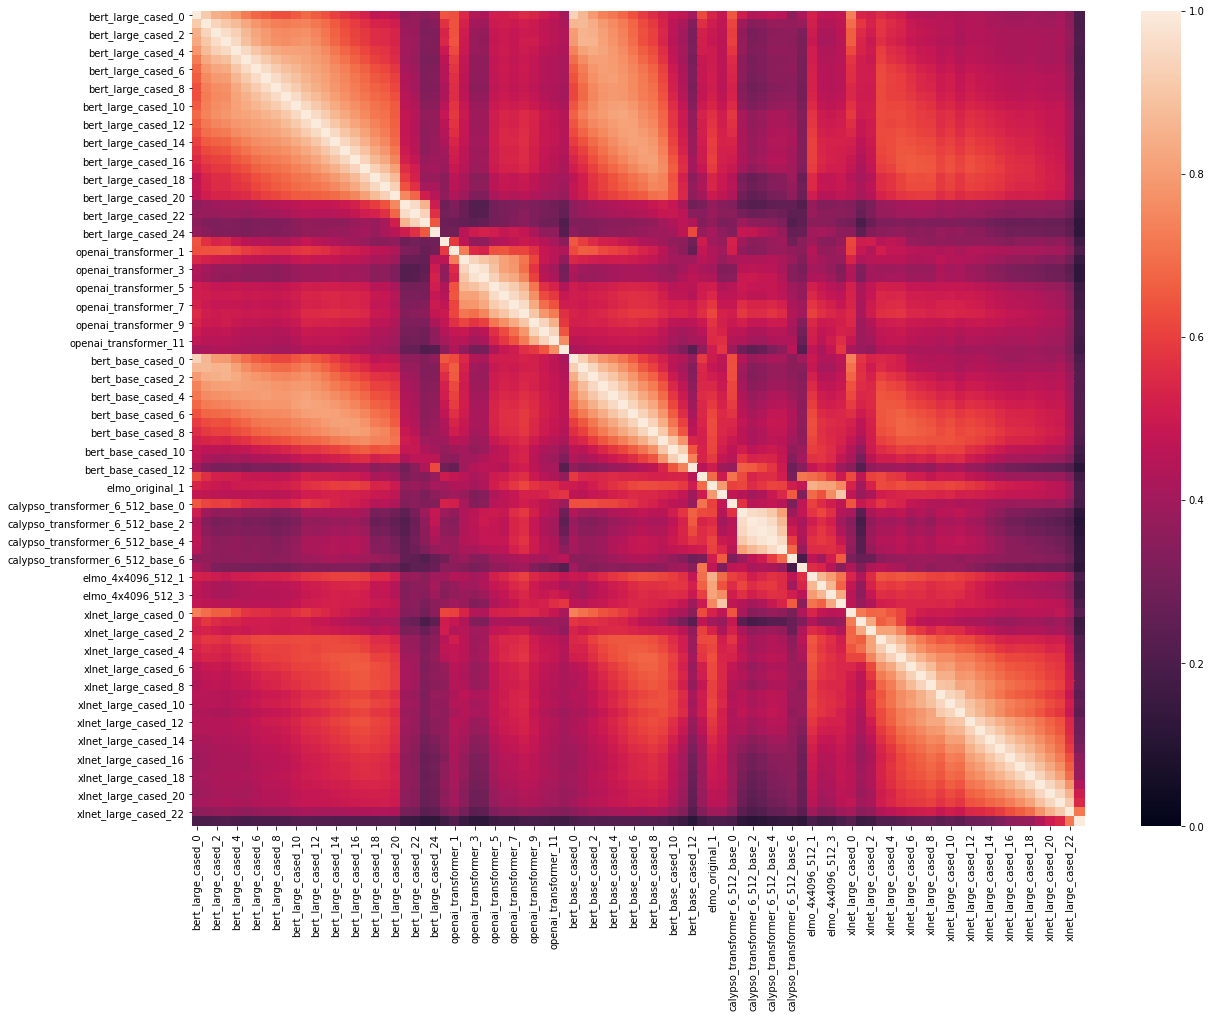

In [42]:
# lincka
sns.heatmap(lincka_df.reindex(lincka_df.columns).fillna(1), vmin=0, vmax=1)

In [40]:
lincka_df.replace?

In [41]:
sns.heatmap?

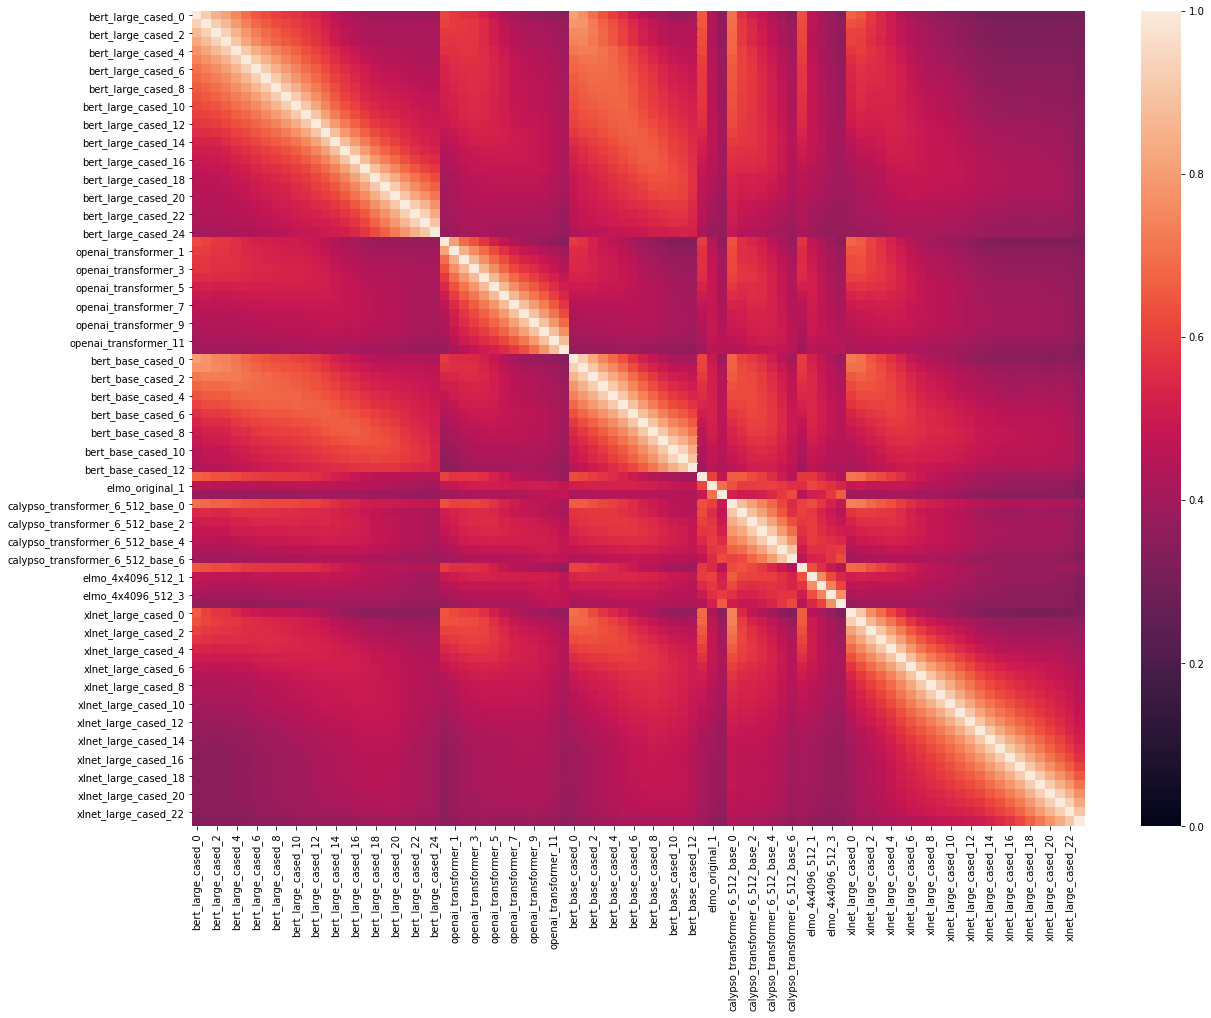

In [43]:
# pwcca
sns.heatmap(pw_sim_df.reindex(pw_sim_df.columns).fillna(1), vmin=0, vmax=1)

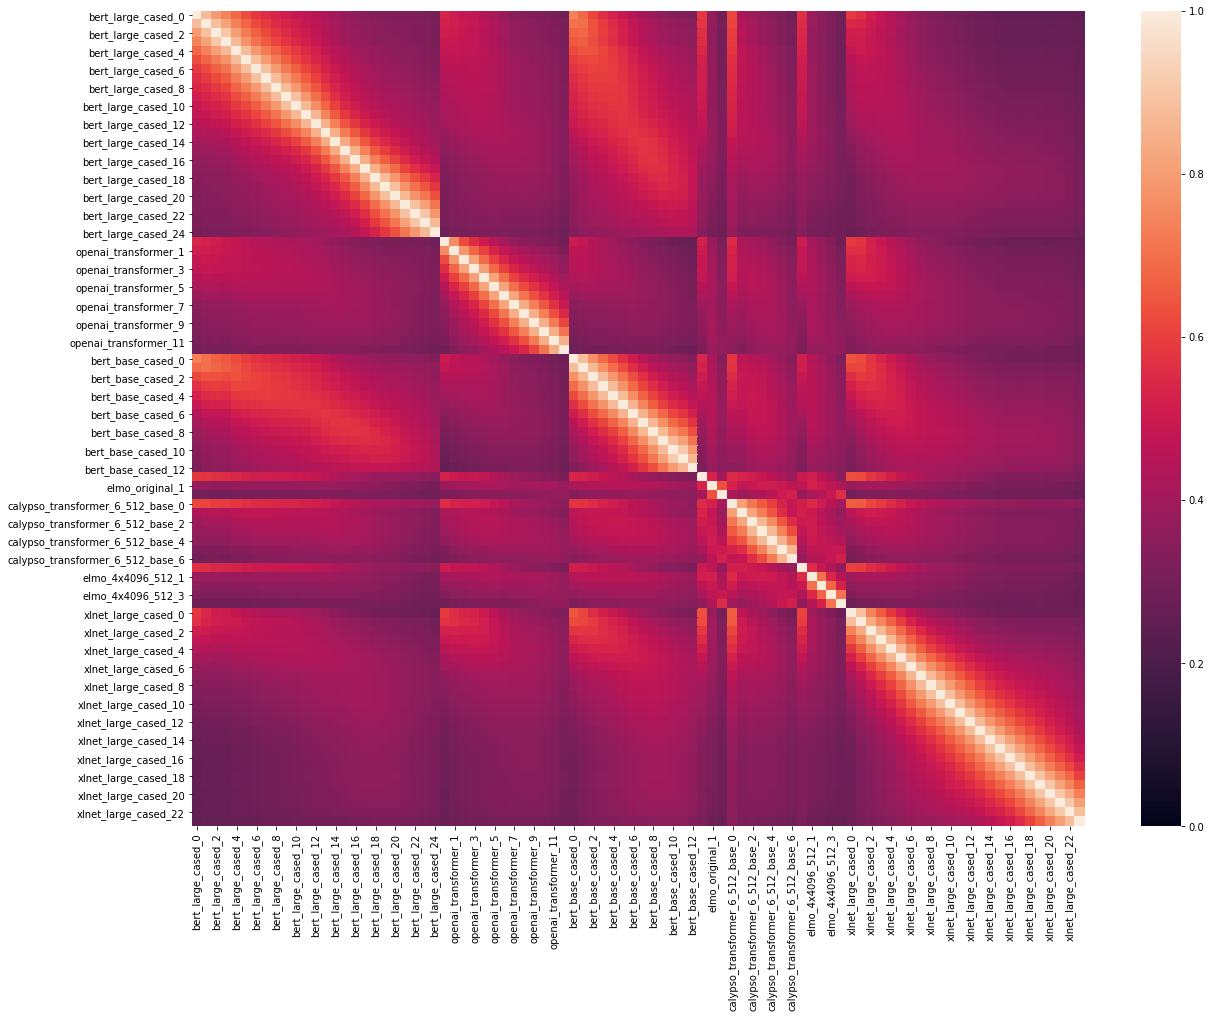

In [44]:
# svcca
sns.heatmap(sv_sim_df.reindex(sv_sim_df.columns).fillna(1), vmin=0, vmax=1)

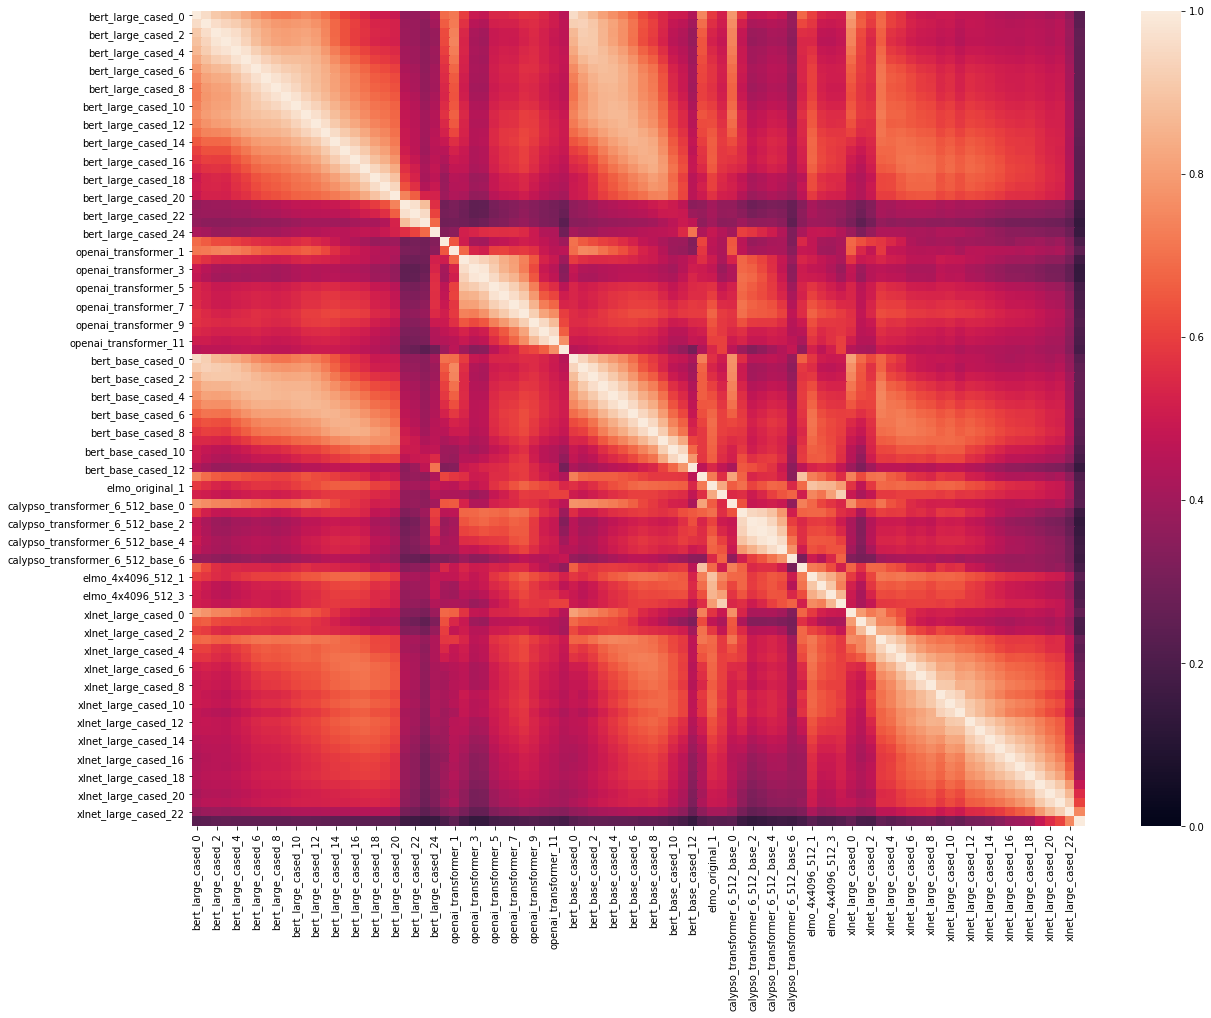

In [45]:
# rbfcka
sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [33]:
# comparing models
# use lincka
model1 = "openai"
model2 = "xlnet"
cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

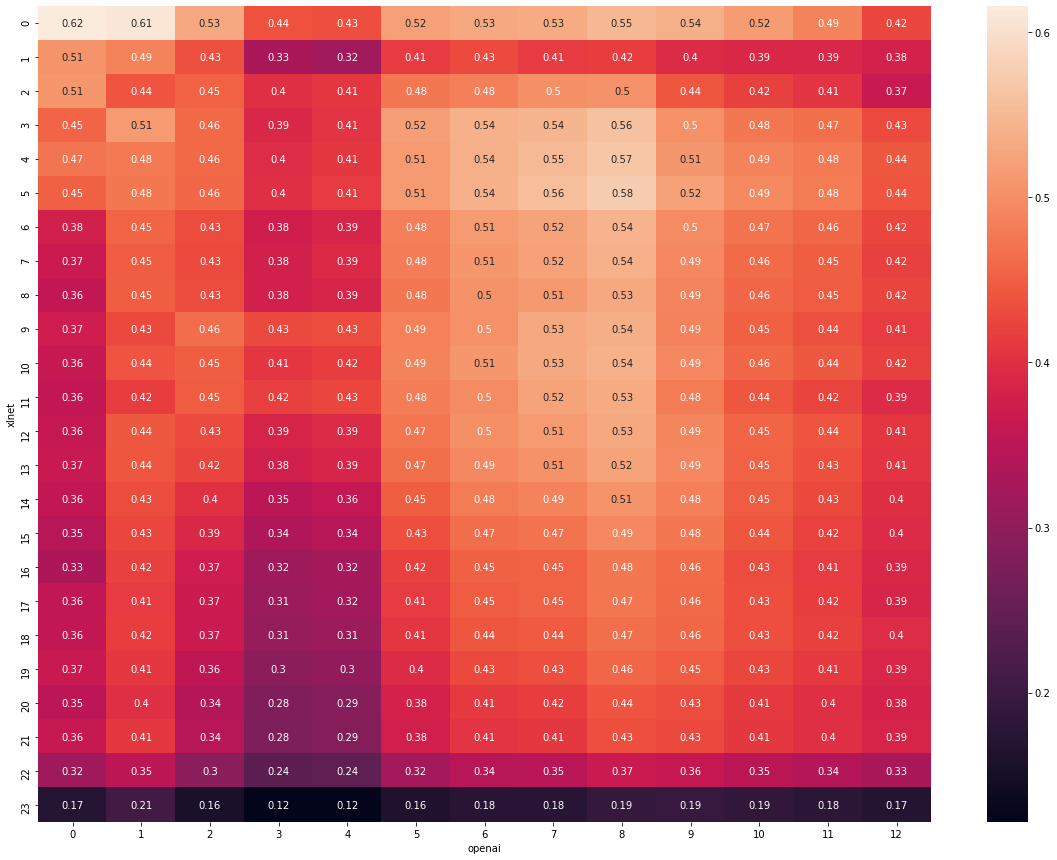

In [34]:
df = lincka_df.loc[rows, cols]

sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
plt.xlabel(model1)
plt.ylabel(model2)
plt.show()